In [2]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle
import seaborn as sns
import os

import matplotlib as mpl
from matplotlib import colors

from msmtools.estimation import transition_matrix as _transition_matrix
from msmtools.analysis import timescales as _timescales

import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral, Ramachandran

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mpl.rcParams['savefig.bbox'] = 'tight'
sns.set_style("white")
sns.set_style({'font.family':'sans-serif', 'font.serif':'Arial'})

In [4]:
def featurizer(hp_dict: Dict, traj_paths: List[str], top_path: str) -> List[np.ndarray]:
    if hp_dict['feature__value'] == 'dihedrals':
        assert hp_dict['dihedrals__which'] == 'all'
        def f(traj: md.Trajectory, **kwargs) -> np.ndarray:
            _, phi = md.compute_phi(traj)
            _, psi = md.compute_psi(traj)
            _, chi1 = md.compute_chi1(traj)
            _, chi2 = md.compute_chi2(traj)
            _, chi3 = md.compute_chi3(traj)
            _, chi4 = md.compute_chi4(traj)
            _, chi5 = md.compute_chi5(traj)
            ftraj = np.concatenate([phi, psi, chi1, chi2, chi3, chi4, chi5], axis=1)
            ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)
            return ftraj

    elif hp_dict['feature__value'] == 'distances':
        def f(traj: md.Trajectory, **kwargs):
            scheme = kwargs['distances__scheme']
            transform = kwargs['distances__transform']
            centre = kwargs['distances__centre']
            steepness = kwargs['distances__steepness']
            ftraj, _ = md.compute_contacts(traj, scheme=scheme)
            if transform=='logistic':
                ftraj = 1.0/(1+np.exp(-steepness*(ftraj - centre)))
            return ftraj
    else:
        raise ValueError
    ftrajs = []
    for traj_path in traj_paths:
        traj = md.load(traj_path, top=top_path)
        ftrajs.append(f(traj, **hp_dict))
    return ftrajs


def tica(hp_dict: Dict[str, Union[float, int, str]], ftrajs: List[np.ndarray]) -> List[np.ndarray]:
    lag = hp_dict['tica__lag']
    stride = hp_dict['tica__stride']
    dim = hp_dict['tica__dim']
    tica = pm.coordinates.tica(ftrajs, lag=lag, dim=dim, kinetic_map=True)
    ttrajs = tica.get_output()
    return ttrajs, tica

def kmeans(hp_dict: Dict, ttrajs: List[np.ndarray], seed: int) -> List[np.ndarray]:
    k = hp_dict['cluster__k']
    max_iter = hp_dict['cluster__max_iter']
    stride = hp_dict['cluster__stride']
    kmeans = pm.coordinates.cluster_kmeans(ttrajs, k=k, max_iter=max_iter, stride=stride, fixed_seed=seed, n_jobs=1)
    dtrajs = kmeans.dtrajs
    return dtrajs, kmeans


def its(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    its_obj = pm.msm.timescales_msm(dtrajs=dtrajs, lags=lags, nits=nits)
    return its_obj.timescales


def score(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    all_vs = []
    for lag in lags: 
        m = pm.msm.estimate_markov_model(dtrajs, lag=lag)
        vs = np.array([m.score(dtrajs, score_k=k) for k in range(2, nits+2)])
        vs = vs.reshape(1, -1)
        all_vs.append(vs)
    all_vs = np.concatenate(all_vs, axis=0)
    return all_vs
        
def bootstrap(ftrajs: List[np.ndarray], rng: np.random.Generator) -> List[np.ndarray]:
    probs = np.array([x.shape[0] for x in ftrajs])
    probs = probs/np.sum(probs)
    ix = np.arange(len(ftrajs))
    new_ix = rng.choice(ix,size=len(ftrajs), p=probs, replace=True)
    return [ftrajs[i] for i in new_ix], new_ix



def summarise(df):
    df_summary = df.groupby(['hp_ix', 'lag', 'process']).agg(median=(0, lambda x: np.quantile(x, 0.5)),
                                                                   lb=(0, lambda x: np.quantile(x, 0.025)),
                                                                   ub=(0, lambda x: np.quantile(x, 0.975)), 
                                                                   count =(0, lambda x: x.shape[0]-x.isna().sum()))
    return df_summary


def samples_to_summary(samples: np.ndarray, lags: List[int],  hp_ix: int)-> pd.DataFrame: 
    """
    samples=np.ndarray[lagtime, process, bs_sample]
    """
    df = pd.concat({(hp_ix, lags[i], j+2): pd.DataFrame(samples[i, j, :]) for i in range(samples.shape[0]) for j in range(samples.shape[1])})
    df.index.rename(('hp_ix', 'lag', 'process', 'bs_ix'), inplace=True)
    df_summary = summarise(df)
    return df_summary

# MSM parameters
protein = 'BBA'
seed = 49587
rng = np.random.default_rng(seed)
lags = list(range(1, 102, 10))
n_bootstraps = 1
nits= 25
lag = 41
hp_ixs = [24,262,121,329]
hp_ix = 331
n_ts = 10

# PCCA+ parameters
n_sets = 3
core_membership_cutoff = 0.9

# Input path 
hps_1 = pd.read_hdf('../BBA/new_ts_hpsample.h5')
hps_2 = pd.read_hdf('../BBA/new_ts_hpsample_missing_best.h5')

summary_paths = [f'../{protein}/summary_batch1.h5', f'../{protein}/summary_batch2.h5', f'../{protein}/summary_batch3.h5']
hp_paths = [f'../{protein}/hpsample.h5', f'../{protein}/new_hpsample.h5', f'../{protein}/new_ts_hpsample_missing_best.h5']
top_path = '../../../1fme/protein.pdb'
traj_paths = list(Path(r'../../../1fme').rglob(f'1FME-*.xtc'))
traj_paths = [str(x) for x in traj_paths]
traj_paths.sort()
ref_path = r'../../../1fme/1fme.pdb'

# source_ts = pd.DataFrame(pd.read_hdf(f'../analysis/{protein}/summary_batch1.h5', key='timescales'))
# source_vs = pd.DataFrame(pd.read_hdf(f'../analysis/{protein}/summary_batch1.h5', key='vamps'))

keep_hp_ixs = [np.array([]), np.array([329, 330, 331, 334, 335]), 
               np.array([340, 341, 342, 343, 344])]

hps = []
timescales = []

for batch_num in range(3):
    keep_ix = keep_hp_ixs[batch_num]
    
    # Hp definitions
    hp = pd.read_hdf(hp_paths[batch_num])
    hp.reset_index(inplace=True)    
    
    # Drop these columns if they exist. 
    for drop_col in ['index', 'Group']:
        if drop_col in hp.columns:
            hp.drop(labels=[drop_col], inplace=True, axis=1)
    if keep_ix.shape[0]>0: 
        hp = hp.loc[hp.hp_ix.isin(keep_ix), :]
    hps.append(hp)
    
    # timescales
    tmp = pd.read_hdf(summary_paths[batch_num], key='timescales')
    tmp.reset_index(inplace=True)
    
    # Drop these columns if they exist. 
    for drop_col in ['index', 'Group']:
        if drop_col in tmp.columns:
            tmp.drop(labels=[drop_col], inplace=True, axis=1)
    
    if keep_ix.shape[0]>0: 
        tmp = tmp.loc[tmp.hp_ix.isin(keep_ix), :]
    timescales.append(tmp)
    
       
timescales = pd.concat(timescales, axis=0)
hps = pd.concat(hps, axis=0)    

print(timescales.shape, hps.shape)

timescales = timescales.merge(hps, on=['hp_ix'], how='left')
timescales['feature'] = timescales.apply(lambda x: f"{x['feature__value']}" if x['feature__value'] =='dihedrals' else f"{x['distances__transform']}-{x['feature__value']}", axis=1)
print(timescales.shape)
timescales.drop_duplicates(inplace=True)
print(timescales.shape)
hps.set_index('hp_ix', inplace=True)

In [241]:
# MSM parameters
protein = 'BBA'
seed = 49587
rng = np.random.default_rng(seed)
lags = list(range(1, 102, 10))
n_bootstraps = 1
nits= 25
lag = 41
hp_ixs = [227, 206, 24, 121, 75]
hp_ix = 75
n_ts = 10

# PCCA+ parameters
n_sets = 2
core_membership_cutoff = 0.9

# Input path 
summary_path = r'../BBA/t2.h5'
top_path = '../../../1fme/protein.pdb'
traj_paths = list(Path(r'../../../1fme').rglob(f'1FME-*.xtc'))
traj_paths = [str(x) for x in traj_paths]
traj_paths.sort()
ref_path = r'../../../1fme/1fme.pdb'

In [249]:
hps.columns

Index(['value', 'datetime_start', 'datetime_complete', 'duration',
       'distances__centre', 'feature__value', 'cluster__k',
       'distances__scheme', 'distances__steepness', 'tica__dim', 'tica__lag',
       'distances__transform', 'state', 'tica__stride', 'cluster__stride',
       'dihedrals__which', 'cluster__max_iter', 'feature', 'rank'],
      dtype='object')

In [242]:
hps = pd.read_hdf(summary_path)

hps.rename(columns=dict(number='hp_ix', 
                        params_centre='distances__centre', 
                        params_feature='feature__value', 
                        params_n_clusters='cluster__k', 
                        params_scheme='distances__scheme', 
                        params_steepness='distances__steepness', 
                        params_tica_dim='tica__dim', 
                        params_tica_lag='tica__lag', 
                        params_transform='distances__transform'), inplace=True)
hps['tica__stride'] = 1
hps['cluster__stride'] = 1
hps['dihedrals__which'] = 'all'
hps['cluster__max_iter'] = 1000
hps['feature'] = hps.apply(lambda x: f"{x['feature__value']}" if x['feature__value'] =='dihedrals' else f"{x['distances__transform']}-{x['feature__value']}", axis=1)

def f(x):
    for short, long in short_names.items(): 
        x = x.replace(short, long)
    return x

short_names = {'dihedrals': 'dihed.','logistic-distances': 'logit(dist.)', 'linear-distances': 
              'dist.'}

hps['feature'] = hps['feature'].apply(f)

hps.sort_values(by='value', inplace=True, axis=0, ascending=False)
hps['rank'] = (np.arange(hps.shape[0])+1).astype(int)

In [233]:
for ix in hp_ixs: print(hps.loc[ix, :].to_dict())

{'hp_ix': 227, 'value': 46614.162448285046, 'datetime_start': Timestamp('2023-03-07 23:29:44.167550'), 'datetime_complete': Timestamp('2023-03-07 23:34:11.801723'), 'duration': Timedelta('0 days 00:04:27.634173'), 'distances__centre': 0.7705615635379226, 'feature__value': 'distances', 'cluster__k': 444, 'distances__scheme': 'ca', 'distances__steepness': 3.288995398092146, 'tica__dim': 20, 'tica__lag': 53, 'distances__transform': 'logistic', 'state': 'COMPLETE', 'tica__stride': 1, 'cluster__stride': 1, 'dihedrals__which': 'all', 'cluster__max_iter': 1000, 'feature': 'logit(dist.)', 'rank': 1}
{'hp_ix': 206, 'value': 31097.308798644823, 'datetime_start': Timestamp('2023-03-07 22:20:42.677832'), 'datetime_complete': Timestamp('2023-03-07 22:24:54.647840'), 'duration': Timedelta('0 days 00:04:11.970008'), 'distances__centre': 0.6393452117225833, 'feature__value': 'distances', 'cluster__k': 386, 'distances__scheme': 'ca', 'distances__steepness': 1.2425240217357503, 'tica__dim': 18, 'tica__l

***
### Compute and check MSM

In [243]:
# Output path 
try:
    hps.set_index(['hp_ix'], inplace=True)
except:
    pass
base_dir = Path(f"{protein}/hp{hp_ix}_{hps.loc[hp_ix,:]['feature']}")
fig_dir = Path.joinpath(base_dir, Path(f"figures"))
fig_dir.mkdir(parents=True, exist_ok=True)

In [244]:
ftrajs_all = featurizer(hps.loc[hp_ix,:].to_dict(), traj_paths, top_path)

# Bootstrap results
ts_samples = []
vs_samples = []

for i in range(n_bootstraps):
    ftrajs = ftrajs_all
    assert len(ftrajs) == len(ftrajs_all)
    
    ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
    dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)
    
    if n_bootstraps>1:
        out_dir = Path.joinpath(base_dir, Path(f'bs_{i}'))
    else:
        out_dir = Path.joinpath(base_dir, Path(f'dtrajs'))
        
    out_dir.mkdir(parents=True, exist_ok=True)
    
    for j in range(len(traj_paths)): 
        traj_path = Path(traj_paths[j]).resolve()
        np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])
        
msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
ts = msm.timescales(n_ts)

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|████████████████████| 164/164 [00:00<00:00, 511.07it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%|  | 0/103 [00:00<?, ?it/s]
initialize kmeans++ centers:  97%|▉| 100/103 [00:01<00:00, 9
100%|█████████████████████| 103/103 [00:16<00:00,  6.25it/s]

100%|███████████████████| 164/164 [00:00<00:00, 2759.48it/s]


In [245]:
_ = msm.pcca(n_sets)

[5311.89871473 2532.06732712 2267.65962805 2076.61360993 1831.28708659
 1706.93617842 1579.19919183 1433.74852101 1321.79453575 1248.25925011]


/tmp/ipykernel_2405690/2688182932.py:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[1].set_ylim([0,8])


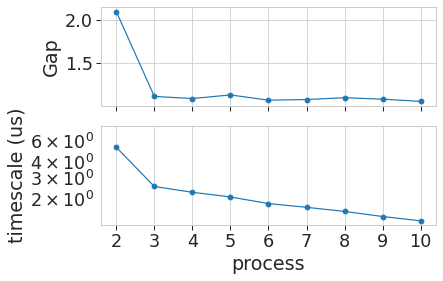

In [210]:
'''
top panel --> plot ratios of ts_n / ts_(n+1)
bottom panel --> values of timescales
'''

print(ts)
with sns.plotting_context('paper', font_scale=2):
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, sharex=True)

    axes[0].plot(np.arange(n_ts-1)+2, ts[:-1]/ts[1:], marker='o')
    axes[0].set_ylabel('Gap')
    
    axes[1].plot(np.arange(n_ts-1)+2, ts[:-1]/1000, marker='o')
    axes[1].set_yscale('log')
    axes[1].set_ylabel('timescale (us)')
    axes[1].set_xlabel('process')
    axes[1].set_ylim([0,8])
    
    axes[0].tick_params(bottom=True, top=False, left=True, right=False)
    axes[1].tick_params(bottom=True, top=False, left=True, right=False)

    plt.savefig(fig_dir.joinpath(f'Timescales.png'), bbox_inches='tight')

In [ ]:
# !!!
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize = (6,6))
    its = pm.msm.its(dtrajs, nits = 5, lags = [1, 10, 50, 100, 500, 1000], n_jobs=10)
    pm.plots.plot_implied_timescales(its, units = 'ns', dt = 1, ax = ax)
    ax.grid(visible=True, axis='y')
    fig.tight_layout()
plt.savefig(fig_path.joinpath(f'its_hp_ix-{hp_ix}.png'), bbox_inches='tight')    

In [ ]:
# !!!
with sns.plotting_context('paper'):
    sns.set_style('whitegrid')
    pm.plots.plot_cktest(msm.cktest(2), figsize = (8,8))
plt.savefig(fig_dir.joinpath(f'ck_hp_ix-{hp_ix}.png'), bbox_inches='tight')

In [246]:
# Check state disconnectivity --- only the largest set of reversibly connected states were used in MSM estimation

print('Fraction of states used = {:f}'.format(msm.active_state_fraction))
print('Fraction of counts used = {:f}'.format(msm.active_count_fraction))

print(f'Microstate assignment: {np.concatenate(ttrajs).shape}')
print(f'Right eigenvectors dimension: {msm.eigenvectors_right().shape}')

# !!! weight populations
print('\nstate\tπ\t\tG/kT\t\tNo.')
population = []
number = []
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    population.append(p)
    number.append(s.shape[0])
    print('{}\t{:f}\t{:f}\t{}'.format(i, p, -np.log(p), s.shape[0]))

Fraction of states used = 1.000000
Fraction of counts used = 1.000000
Microstate assignment: (325039, 2)
Right eigenvectors dimension: (103, 103)

state	π		G/kT		No.
0	0.279064	1.276312	24
1	0.720936	0.327206	79


In [247]:
Y = np.concatenate(ttrajs)

dists = msm.metastable_distributions.copy()
dists[msm.metastable_memberships.T<core_membership_cutoff] = 0
dists = dists/np.sum(dists, axis=1)[:, np.newaxis]

max_dists = dists.copy()
mask = max_dists==np.tile(np.max(max_dists, axis=1)[:, np.newaxis], (max_dists.shape[1]))
max_ix = np.where(mask)[1]
max_dists[mask] = 1
max_dists[~mask] = 0

In [197]:
# Mapping test conformations using maximum likelihood MSM 

test_traj_path = [r'../../../1fme/1fme.pdb']
test_labels = ['1FME']
ftraj_test = featurizer(hps.loc[hp_ix, :].to_dict(), test_traj_path, top_path)
ftraj_test_tica = tica_mod.transform(ftraj_test)
microstate = kmeans_mod.assign(ftraj_test_tica)
metastate = msm.metastable_assignments[microstate]
test_dict = {label:[test_traj_path[i], microstate[i][0], metastate[i][0]] for i, label in enumerate(test_labels)}

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


***
### Check eigenvector

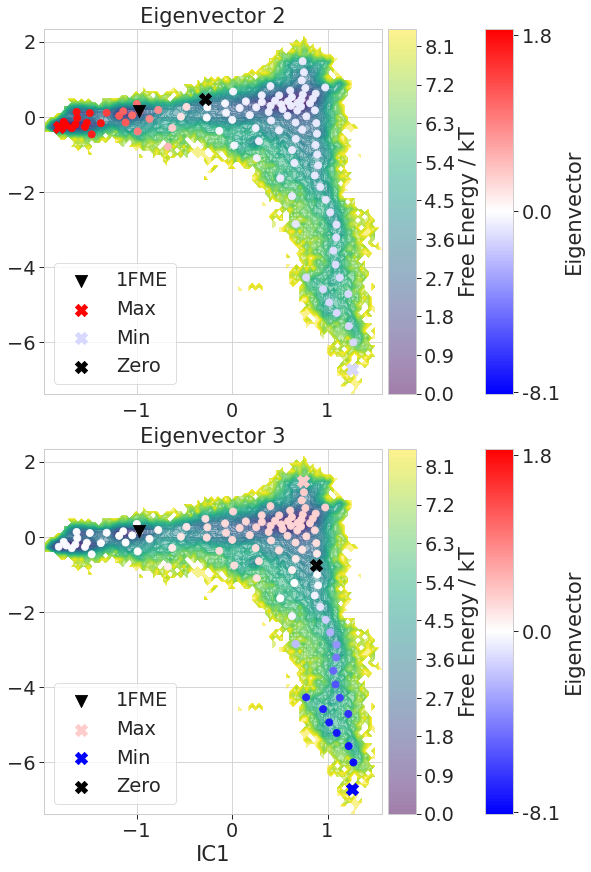

In [182]:
n_egv = 2
axes = []

with sns.plotting_context('paper', font_scale=2.2):
    fig = plt.figure(figsize=(n_egv*6, n_egv*6), constrained_layout=True)
    gs = fig.add_gridspec(nrows=n_egv*12, ncols=n_egv*12)
    
    for i in range(n_egv):
        axes.append([fig.add_subplot(gs[i*12:(i+1)*12, 0:12]), fig.add_subplot(gs[i*12:(i+1)*12,12]), fig.add_subplot(gs[i*12:(i+1)*12,13])])
    
    for i_ev, ax in enumerate(axes): 
        #vmin = np.min(msm.eigenvectors_right()[:, 1:3])
        #vmax = np.max(msm.eigenvectors_right()[:, 1:3])
        #lnorm = colors.Normalize(vmin=vmin, vmax=vmax)
        vmin = np.min(msm.eigenvectors_right()[:, 1:3]) 
        vmax = np.max(msm.eigenvectors_right()[:, 1:3]) 
        divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

        if Y.shape[1]==1:
            pm.plots.plot_feature_histograms(Y, ax=ax)
            x = kmeans_mod.clustercenters[:, 0]
            y = np.repeat(0,kmeans_mod.clustercenters.shape[0])
        else:
            _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                                alpha=0.5, weights=np.concatenate(msm.trajectory_weights()),
                                                cbar_label='Free Energy / kT', 
                                                ax=ax[0], cax=ax[1])
            x = kmeans_mod.clustercenters[:, 0]
            y = kmeans_mod.clustercenters[:, 1]    
        
        # Cluster centers and colorbar
        ms = ax[0].scatter(x=x, y=y, c=msm.eigenvectors_right()[:, i_ev+1], cmap='bwr', norm=divnorm, s=50)
        cbar = plt.colorbar(ms, cax=ax[2], ticks=[np.ceil(vmin*10)/10, 0, np.floor(vmax*10)/10])
        cbar.ax.set_yticklabels([np.ceil(vmin*10)/10, 0.0, np.floor(vmax*10)/10])
        cbar.ax.set_ylabel('Eigenvector')
        
        for k,v in test_dict.items():
            ax[0].scatter(x=x[v[1]], y=y[v[1]], c='black', marker='v', s=150, label=k, alpha=1)
        
        # Label extreme eigenvalues
        egv_max = msm.eigenvectors_right()[:, i_ev+1].argmax()
        egv_min = msm.eigenvectors_right()[:, i_ev+1].argmin()
        egv_zero = abs(msm.eigenvectors_right()[:, i_ev+1]).argmin()
        ax[0].scatter(x=x[egv_max], y=y[egv_max], c=msm.eigenvectors_right()[egv_max, i_ev+1], 
                      cmap='bwr', norm=divnorm, marker='X', s=150, alpha=1, label='Max')
        ax[0].scatter(x=x[egv_min], y=y[egv_min], c=msm.eigenvectors_right()[egv_min, i_ev+1], 
                      cmap='bwr', norm=divnorm, marker='X', s=150, alpha=1, label='Min')
        ax[0].scatter(x=x[egv_zero], y=y[egv_zero], c='k', marker='X', s=150, alpha=1, label='Zero')
    
        plt.locator_params(nbins=5, axis='both')
        ax[0].set_title(f'Eigenvector {i_ev+2}')
        ax[0].grid(visible=True, axis='both')
        
        ax[0].tick_params(bottom=True, top=False, left=True, right=False)
        ax[0].legend(loc='lower left')
        
    axes[0][0].tick_params(bottom=False, top=False, left=True, right=False)
    axes[1][0].tick_params(bottom=True, top=False, left=True, right=False)
    axes[1][0].set_xlabel('IC1')
    
    plt.savefig(fig_dir.joinpath(f'egvs.png'), bbox_inches='tight')    
    plt.show()

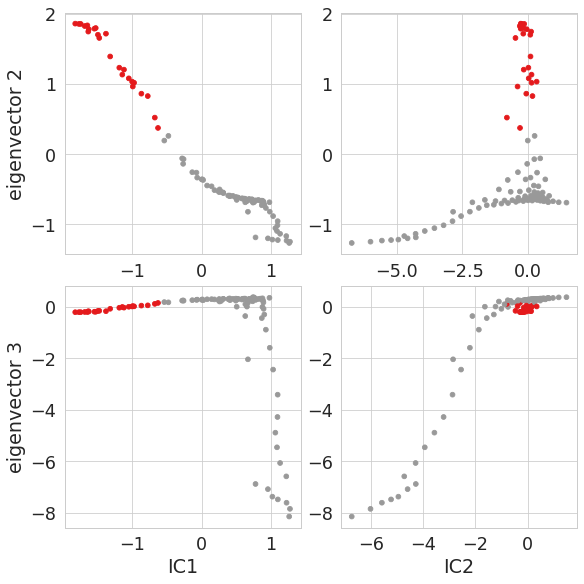

In [248]:
# Check the values of eigenvector along IC
with sns.plotting_context('paper', font_scale=2):
    fig, axes = plt.subplots(2,2, figsize=(8,8), constrained_layout=True)
    for i_set, row in enumerate(axes):
        row[0].scatter(x=kmeans_mod.clustercenters[:, 0], y = msm.eigenvectors_right()[:, i_set+1], c=msm.metastable_assignments, cmap='Set1')
        row[1].scatter(x=kmeans_mod.clustercenters[:, 1], y = msm.eigenvectors_right()[:, i_set+1], c=msm.metastable_assignments, cmap='Set1')
        
    axes[1][0].set_xlabel(f'IC1')
    axes[1][1].set_xlabel(f'IC2')
    axes[0][0].set_ylabel(f'eigenvector 2')
    axes[1][0].set_ylabel(f'eigenvector 3')
    
    plt.locator_params(nbins=5, axis='both')
    plt.savefig(fig_dir.joinpath(f'{n_sets}_egvs_detailed.png'), bbox_inches='tight')    
    plt.show()

***
### Check state centers

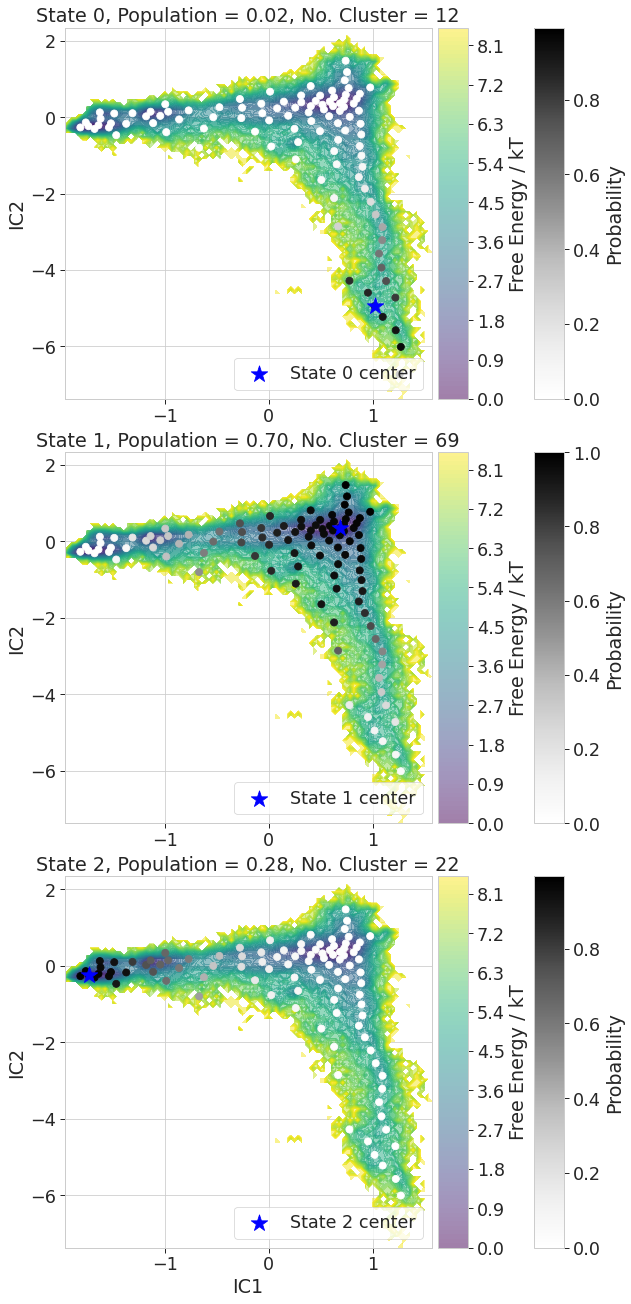

In [198]:
mem = msm.metastable_memberships.transpose()
axes = []

with sns.plotting_context('paper', font_scale=2):
    fig = plt.figure(figsize=(n_sets*6, n_sets*6), constrained_layout=True)
    gs = fig.add_gridspec(nrows=n_sets*12, ncols=n_sets*12)
    
    for i in range(n_sets):
        axes.append([fig.add_subplot(gs[i*12:(i+1)*12, 0:12]), fig.add_subplot(gs[i*12:(i+1)*12,12]), fig.add_subplot(gs[i*12:(i+1)*12,13])])
    
    for i_set, ax in enumerate(axes):
        if Y.shape[1]==1:
            pm.plots.plot_feature_histograms(Y, ax=ax[0])
            x = kmeans_mod.clustercenters[:, 0]
            y = np.repeat(0,kmeans_mod.clustercenters.shape[0])
        else:
            _, _ = pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], cmap='viridis', 
                                                alpha=0.5, weights=np.concatenate(msm.trajectory_weights()),
                                                cbar_label='Free Energy / kT', 
                                                ax=ax[0], cax=ax[1])
            x = kmeans_mod.clustercenters[:, 0]
            y = kmeans_mod.clustercenters[:, 1]    
        
        # Cluster centers
        ms = ax[0].scatter(x=x, y=y, c=mem[i_set], cmap='Greys', s=50, 
                           vmin=mem[i_set].min(), vmax=mem[i_set].max())
        cbar = plt.colorbar(ms, cax=ax[2])
        cbar.ax.set_ylabel('Probability')
        
        # State centers
        ax[0].scatter(x=x[max_ix[i_set]],y=y[max_ix[i_set]], color='b', marker='*', s=300, label=f'State {i_set} center')
        
        ax[0].grid(visible=True,axis='both')
        ax[0].set_title(f'State {i_set}, Population = {population[i_set]:.2f}, No. Cluster = {number[i_set]}')
        ax[0].tick_params(bottom=True, top=False, left=True, right=False)
        ax[0].legend(loc='lower right')
        ax[0].set_ylabel('IC2')
    '''
    for i, m in enumerate(microstate):
        axes[metastate[i][0]].scatter(x=x[m],y=y[m], color='r', marker='v', s=120, label= test_labels[i])
    '''    
    axes[i_set][0].set_xlabel('IC1')
    plt.locator_params(nbins=5, axis='both')
    
    plt.savefig(fig_dir.joinpath(f'{n_sets}_sc.png'), bbox_inches='tight')    
    plt.show()

***
### Sample cluster center

In [199]:
is_single_core = True
if is_single_core: 
    samples = msm.sample_by_distributions(max_dists, 100)
else: 
    samples = msm.sample_by_distributions(dists, 100)
    
ref = md.load(ref_path)

state_out_dir = base_dir.joinpath('states')
state_out_dir.mkdir(exist_ok=True, parents=True)

In [200]:
states = []

for sample_ix in range(len(samples)):

    outfile = str(state_out_dir.joinpath(f'{n_sets}sets_state_{sample_ix}_is_single_core-{is_single_core}.pdb'))
    
    traj = pm.coordinates.save_traj(traj_paths, samples[sample_ix], 
                                 outfile=None, top=top_path)
    traj.superpose(reference=ref)
    states.append(traj)
    traj.save_pdb(str(outfile))
    
rmsds = [md.rmsd(target=x, reference=ref) for x in states]
rmsds_df = pd.DataFrame({f"state_{i}": rmsd*10 for i, rmsd in enumerate(rmsds)}).melt()

100%|██████████████████████| 35/35 [00:00<00:00, 976.00it/s]


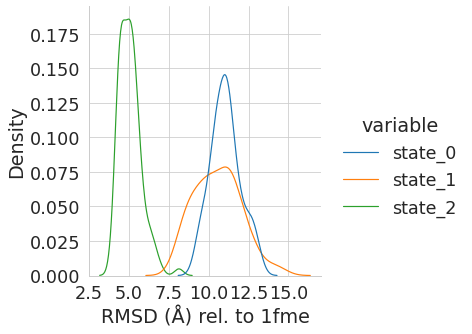

In [201]:
with sns.plotting_context('paper', font_scale=2):
    sns.displot(data=rmsds_df, hue='variable', x='value', kind='kde')
    plt.xlabel(f'RMSD (Å) rel. to 1fme')
    plt.grid(visible=True, axis='both')
    plt.savefig(fig_dir.joinpath(f'{n_sets}sets_rmsd_to_xtal_single_core-{is_single_core}.png'), bbox_inches='tight')

***
### Sample extreme eigenvalues

In [202]:
samples = {}
for i in range(n_egv):
    egv_max = msm.eigenvectors_right()[:, i+1].argmax()
    egv_min = msm.eigenvectors_right()[:, i+1].argmin()
    egv_zero = abs(msm.eigenvectors_right()[:, i+1]).argmin()
    samples[f'egv{i+2}_max_{egv_max}'] = msm.sample_by_state(100, [egv_max])
    samples[f'egv{i+2}_min_{egv_min}'] = msm.sample_by_state(100, [egv_min])
    samples[f'egv{i+2}_zero_{egv_zero}'] = msm.sample_by_state(100, [egv_zero])

In [189]:
rmsds = []

with open(state_out_dir.joinpath('out.dat'), 'w') as f: 
    f.writelines(f'Protein {protein}; hp_id {hp_ix}\n')
    
    for n, sample in samples.items():
        outfile = str(state_out_dir.joinpath(f'{n}.pdb'))

        traj = pm.coordinates.save_traj(traj_paths, sample, outfile=None, top=top_path)
        traj.superpose(reference=ref)
        states.append(traj)
        traj.save_pdb(str(outfile))

        # Compute rg
        rg = md.compute_rg(traj)
        ave_rg, std_rg = np.mean(rg), np.std(rg)

        # Compute rmsd within samples
        rmsd_list = []
        for i in range(len(traj)):
            rmsd_list.append(md.rmsd(traj, traj[i]))
        rmsd_array = np.array(rmsd_list)*10
        ave_rmsd, std_rmsd = np.mean(rmsd_array), np.std(rmsd_array)
        
        # Compute rmsd wrt ref
        rmsd = md.rmsd(target=traj, reference=ref)*10
        ave_ref_rmsd, std_ref_rmsd = np.mean(rmsd), np.std(rmsd)
        rmsds.append(rmsd)
        
        f.writelines(f'{n}\naverage_rg {ave_rg}, std_rg {std_rg}\naverage_rmsd {ave_rmsd}, std_rmsd {std_rmsd}\nave_ref_rmsd {ave_ref_rmsd}, std_ref_rmsd {std_ref_rmsd}\n\n')
    
#rmsds = [md.rmsd(target=x, reference=ref) for x in states]
rmsds_df = pd.DataFrame({f"state_{i}": rmsd for i, rmsd in enumerate(rmsds)}).melt()


100%|██████████████████████| 45/45 [00:00<00:00, 954.53it/s]


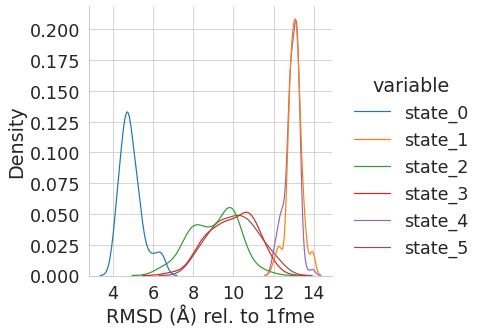

In [190]:
with sns.plotting_context('paper', font_scale=2):
    sns.displot(data=rmsds_df, hue='variable', x='value', kind='kde')
    plt.xlabel(f'RMSD (Å) rel. to 1fme')
    plt.grid(visible=True, axis='both')
    plt.savefig(fig_dir.joinpath(f'{n_egv}egvs_extreme_rmsd_to_xtal.png'), bbox_inches='tight')

In [203]:
!tar chvfz BBA.tar.gz ./BBA

./BBA/
./BBA/.ipynb_checkpoints/
./BBA/hp75_logit(dist.)/
./BBA/hp75_logit(dist.)/dtrajs/
./BBA/hp75_logit(dist.)/dtrajs/1FME-0-protein-027.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-0-protein-067.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-1-protein-049.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-0-protein-061.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-1-protein-019.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-1-protein-045.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-0-protein-000.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-1-protein-037.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-1-protein-046.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-1-protein-003.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-0-protein-055.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-0-protein-020.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-0-protein-066.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-0-protein-011.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-0-protein-057.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-0-protein-071.npy
./BBA/hp75_logit(dist.)/dtrajs/1FME-0-protein-

./BBA/hp75_logit(dist.)/states/3sets_state_2_is_single_core-True.pdb
./BBA/hp75_logit(dist.)/states/3sets_state_1_is_single_core-True.pdb
./BBA/hp75_logit(dist.)/states/egv2_max_29.pdb
./BBA/hp75_logit(dist.)/states/2sets_state_1_is_single_core-True.pdb
./BBA/hp75_logit(dist.)/states/egv2_zero_62.pdb
./BBA/hp75_logit(dist.)/states/egv3_zero_23.pdb
./BBA/hp75_logit(dist.)/states/egv2_min_48.pdb
./BBA/hp75_logit(dist.)/states/3sets_state_0_is_single_core-True.pdb
./BBA/hp75_logit(dist.)/states/egv3_max_60.pdb
./BBA/hp75_logit(dist.)/states/egv3_min_48.pdb
./BBA/hp75_logit(dist.)/states/out.dat
./BBA/hp75_logit(dist.)/figures/
./BBA/hp75_logit(dist.)/figures/2egvs_extreme_rmsd_to_xtal.png
./BBA/hp75_logit(dist.)/figures/3sets_rmsd_to_xtal_single_core-True.png
./BBA/hp75_logit(dist.)/figures/2sets_rmsd_to_xtal_single_core-True.png
./BBA/hp75_logit(dist.)/figures/egvs_detailed.png
./BBA/hp75_logit(dist.)/figures/3_sc.png
./BBA/hp75_logit(dist.)/figures/2_sc.png
./BBA/hp75_logit(dist.)/figur

./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-033.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-015.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-111.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-014.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-072.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-038.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-092.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-036.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-1-protein-026.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-095.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-086.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-017.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-032.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-022.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-048.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-1-protein-029.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-0-protein-103.npy
./BBA/hp24_logit(dist.)/dtrajs/1FME-1-protein-051.npy
./BBA/hp24_logit(dist.)/stat

./BBA/hp206_logit(dist.)/states/egv2_zero_152.pdb
./BBA/hp206_logit(dist.)/states/egv2_min_121.pdb
./BBA/hp206_logit(dist.)/states/egv3_min_25.pdb
./BBA/hp206_logit(dist.)/states/2sets_state_1_is_single_core-True.pdb
./BBA/hp206_logit(dist.)/states/egv3_zero_232.pdb
./BBA/hp206_logit(dist.)/states/egv2_max_25.pdb
./BBA/hp206_logit(dist.)/states/egv3_max_327.pdb
./BBA/hp206_logit(dist.)/states/out.dat
./BBA/hp206_logit(dist.)/figures/
./BBA/hp206_logit(dist.)/figures/2egvs_extreme_rmsd_to_xtal.png
./BBA/hp206_logit(dist.)/figures/2sets_rmsd_to_xtal_single_core-True.png
./BBA/hp206_logit(dist.)/figures/2_sc.png
./BBA/hp206_logit(dist.)/figures/egvs.png
./BBA/hp206_logit(dist.)/figures/Timescales.png
./BBA/hp331_logit(dist.)/
./BBA/hp331_logit(dist.)/.ipynb_checkpoints/
./BBA/hp331_logit(dist.)/.ipynb_checkpoints/Untitled-checkpoint.ipynb
./BBA/hp331_logit(dist.)/dtrajs/
./BBA/hp331_logit(dist.)/dtrajs/1FME-0-protein-027.npy
./BBA/hp331_logit(dist.)/dtrajs/1FME-0-protein-067.npy
./BBA/hp3

./BBA/hp331_logit(dist.)/states/3sets_state_1_is_single_core-True.pdb
./BBA/hp331_logit(dist.)/states/egv2_min_6.pdb
./BBA/hp331_logit(dist.)/states/egv2_zero_72.pdb
./BBA/hp331_logit(dist.)/states/egv3_max_9.pdb
./BBA/hp331_logit(dist.)/states/egv3_min_4.pdb
./BBA/hp331_logit(dist.)/states/egv3_zero_162.pdb
./BBA/hp331_logit(dist.)/states/egv2_max_4.pdb
./BBA/hp331_logit(dist.)/states/3sets_state_0_is_single_core-True.pdb
./BBA/hp331_logit(dist.)/states/out.dat
./BBA/hp331_logit(dist.)/Untitled.ipynb
./BBA/hp331_logit(dist.)/figures/
./BBA/hp331_logit(dist.)/figures/2egvs_extreme_rmsd_to_xtal.png
./BBA/hp331_logit(dist.)/figures/3sets_rmsd_to_xtal_single_core-True.png
./BBA/hp331_logit(dist.)/figures/3_sc.png
./BBA/hp331_logit(dist.)/figures/egvs.png
./BBA/hp331_logit(dist.)/figures/Timescales.png
./BBA/hp227_logit(dist.)/
./BBA/hp227_logit(dist.)/dtrajs/
./BBA/hp227_logit(dist.)/dtrajs/1FME-0-protein-027.npy
./BBA/hp227_logit(dist.)/dtrajs/1FME-0-protein-067.npy
./BBA/hp227_logit(dis

./BBA/hp227_logit(dist.)/states/3sets_state_2_is_single_core-True.pdb
./BBA/hp227_logit(dist.)/states/egv3_min_5.pdb
./BBA/hp227_logit(dist.)/states/3sets_state_1_is_single_core-True.pdb
./BBA/hp227_logit(dist.)/states/2sets_state_1_is_single_core-True.pdb
./BBA/hp227_logit(dist.)/states/egv3_zero_152.pdb
./BBA/hp227_logit(dist.)/states/egv2_zero_241.pdb
./BBA/hp227_logit(dist.)/states/egv2_max_5.pdb
./BBA/hp227_logit(dist.)/states/egv3_max_432.pdb
./BBA/hp227_logit(dist.)/states/3sets_state_0_is_single_core-True.pdb
./BBA/hp227_logit(dist.)/states/egv2_min_40.pdb
./BBA/hp227_logit(dist.)/states/out.dat
./BBA/hp227_logit(dist.)/figures/
./BBA/hp227_logit(dist.)/figures/2egvs_extreme_rmsd_to_xtal.png
./BBA/hp227_logit(dist.)/figures/3sets_rmsd_to_xtal_single_core-True.png
./BBA/hp227_logit(dist.)/figures/2sets_rmsd_to_xtal_single_core-True.png
./BBA/hp227_logit(dist.)/figures/egvs_detailed.png
./BBA/hp227_logit(dist.)/figures/3_sc.png
./BBA/hp227_logit(dist.)/figures/2_sc.png
./BBA/hp22

./BBA/hp262_logit(dist.)/states/3sets_state_2_is_single_core-True.pdb
./BBA/hp262_logit(dist.)/states/egv2_min_178.pdb
./BBA/hp262_logit(dist.)/states/3sets_state_1_is_single_core-True.pdb
./BBA/hp262_logit(dist.)/states/egv3_min_3.pdb
./BBA/hp262_logit(dist.)/states/egv3_max_9.pdb
./BBA/hp262_logit(dist.)/states/egv2_max_3.pdb
./BBA/hp262_logit(dist.)/states/3sets_state_0_is_single_core-True.pdb
./BBA/hp262_logit(dist.)/states/egv3_zero_172.pdb
./BBA/hp262_logit(dist.)/states/out.dat
./BBA/hp262_logit(dist.)/figures/
./BBA/hp262_logit(dist.)/figures/2egvs_extreme_rmsd_to_xtal.png
./BBA/hp262_logit(dist.)/figures/3sets_rmsd_to_xtal_single_core-True.png
./BBA/hp262_logit(dist.)/figures/3_sc.png
./BBA/hp262_logit(dist.)/figures/egvs.png
./BBA/hp262_logit(dist.)/figures/Timescales.png
